In [1]:
# !pip install bitsandbytes accelerate xformers==0.0.29 peft trl triton
# !pip install cut_cross_entropy unsloth_zoo
# !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
# !pip install unsloth

In [2]:
from unsloth import FastLanguageModel
from transformers import BitsAndBytesConfig
import torch
RANDOM_SEED = 42
max_seq_length = 2048
dtype = None
load_in_4bit = True
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit" 
#model_name = "DeepSeek-R1-Distill-Qwen-32B-unsloth-bnb-4bit" 现存不足
model_name = "deepseek-r1-distill-llama-8b-unsloth-bnb-4bit-rule-extractor-v2"
#model_name = "DeepSeek-R1-Distill-Qwen-14B-unsloth-bnb-4bit-rule-extractor-v2"
#model_name = "istral-Small-24B-Instruct-2501-unsloth-bnb-4bit-rule-extractor-v2all"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    #use_safetensors=False,  # Disable safetensors if issue persists
  )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    NVIDIA vGPU-32GB. Num GPUs = 1. Max memory: 31.503 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:
#tokenizer.pad_token = tokenizer.eos_token  # 对于没有 pad_token 的模型（如 GPT-2）
#tokenizer.padding_side = "right"           # 生成任务通常右侧填充

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = RANDOM_SEED,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Already have LoRA adapters! We shall skip this step.


In [5]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset
import json
import re

In [6]:
import random
# 配置参数
#MODEL_NAME = "DeepSeek-R1-Distill-Qwen-7B"
new_dataset = False
if new_dataset:
    DATA_PATH = "NSFTdatasetv3_na.json"
    OUTPUT_DIR = "./"+model_name+"_law_extractor"
    torch.manual_seed(RANDOM_SEED)
    with open(DATA_PATH) as f:
        raw_data = json.load(f)
    #json.dumps(raw_data, ensure_ascii=False, indent=2)
    train_data = []
    test_data = []
    test_size = 0.2
    split_index = int(len(raw_data) * (1 - test_size))
    random.seed(RANDOM_SEED)  # 固定随机种子
    random.shuffle(raw_data)
    train_data = raw_data[:split_index]
    test_data = raw_data[split_index:]
    TEST_SAVE_PATH = DATA_PATH.split('.')[0]+"_test_data.json"
    TRAIN_SAVE_PATH = DATA_PATH.split('.')[0]+"_train_data.json"
    with open(TEST_SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(test_data, f, ensure_ascii=False, indent=2)  # 格式化保存
    with open(TRAIN_SAVE_PATH, "w", encoding="utf-8") as f:
        json.dump(train_data, f, ensure_ascii=False, indent=2)  # 格式化保存
else:
    DATA_PATH = "NSFTdatasetv3_na_train_data.json"
    with open(DATA_PATH) as f:
        train_data = json.load(f)



In [7]:
from formatting import formatting_prompts_func_sft,formatting_prompts_func_na
EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN
dataset_sft = Dataset.from_list(train_data).map(formatting_prompts_func_sft)
dataset_na = Dataset.from_list(train_data).map(formatting_prompts_func_na)
# 修复：清洗数据，避免 label 为 list 导致训练报错

def clean_data(dataset):
    cleaned_data = []
    for example in dataset:
        cleaned_data.append({
        'text': example['text']+EOS_TOKEN if isinstance(example, dict) and 'text' in example else example
    })
    return cleaned_data

dataset = clean_data(dataset_sft)+clean_data(dataset_na)
random.shuffle(dataset)
dataset = Dataset.from_list(dataset)
dataset
#Dataset.from_list(random.shuffle(clean_data(dataset_sft)+clean_data(dataset_na)))

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 80
})

In [8]:
tokenized_sample = tokenizer(
    text=dataset['text'],
    max_length=max_seq_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt",
)
print("input_ids 的维度：", tokenized_sample["input_ids"].shape)
print("attention_mask 的维度：", tokenized_sample["attention_mask"].shape)

input_ids 的维度： torch.Size([80, 2048])
attention_mask 的维度： torch.Size([80, 2048])


In [9]:
from trl import SFTTrainer,DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#response_template = "### Response:"
#collator = DataCollatorForCompletionOnlyLM(response_template=response_template, tokenizer=tokenizer)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = 'text',
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    #data_collator=collator,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 2,
        warmup_steps = 2,
        num_train_epochs = 1, # Set this for 1 full training run.
        #max_steps = 80,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = RANDOM_SEED,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/80 [00:00<?, ? examples/s]

In [10]:
for i in range(0,20):
    epoch = i + 1
    trainer_stats = trainer.train()
    
    outputpath = model_name.split('.')[0]+"-rule-extractor-v3-continue-e"+str(epoch)
    model.save_pretrained(outputpath)
    tokenizer.save_pretrained(outputpath)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.633900
2,0.622600
3,0.312800
4,0.367000
5,0.314100
6,0.198200
7,0.234800
8,0.128200
9,0.120200
10,0.096100


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.072400
2,0.043700
3,0.050200
4,0.073400
5,0.061300
6,0.067400
7,0.090500
8,0.059600
9,0.055600
10,0.041000


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.034700
2,0.022100
3,0.020900
4,0.041700
5,0.037700
6,0.031200
7,0.047300
8,0.036400
9,0.030600
10,0.021200


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.019300
2,0.014500
3,0.012000
4,0.022900
5,0.026300
6,0.021300
7,0.027300
8,0.026700
9,0.025300
10,0.013800


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.015700
2,0.021300
3,0.010600
4,0.016900
5,0.018900
6,0.019100
7,0.019500
8,0.023800
9,0.022000
10,0.011600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.009700
2,0.014400
3,0.010300
4,0.012900
5,0.012100
6,0.012100
7,0.014500
8,0.017300
9,0.015600
10,0.010700


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.011500
2,0.013100
3,0.008300
4,0.013200
5,0.012700
6,0.016700
7,0.014700
8,0.016300
9,0.020400
10,0.010200


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.009600
2,0.015400
3,0.008400
4,0.011700
5,0.012500
6,0.014700
7,0.018300
8,0.023200
9,0.018000
10,0.009900


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.010200
2,0.012400
3,0.009400
4,0.008400
5,0.009500
6,0.012600
7,0.011800
8,0.012000
9,0.017500
10,0.008600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.007300
2,0.012100
3,0.008300
4,0.007700
5,0.009100
6,0.009800
7,0.011100
8,0.012200
9,0.010500
10,0.007700


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.008600
2,0.008200
3,0.009700
4,0.006900
5,0.007600
6,0.011500
7,0.009400
8,0.012100
9,0.014800
10,0.012100


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.007100
2,0.007800
3,0.008600
4,0.006900
5,0.007700
6,0.008900
7,0.009600
8,0.010700
9,0.010100
10,0.008000


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.006600
2,0.007900
3,0.007500
4,0.007100
5,0.008300
6,0.010900
7,0.008700
8,0.009800
9,0.011300
10,0.006800


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.006100
2,0.008000
3,0.006600
4,0.005700
5,0.006500
6,0.012400
7,0.011100
8,0.011100
9,0.009600
10,0.007200


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.006200
2,0.007600
3,0.006800
4,0.005600
5,0.006900
6,0.007500
7,0.008200
8,0.009000
9,0.010600
10,0.006600


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.005900
2,0.008200
3,0.006500
4,0.007000
5,0.006800
6,0.007300
7,0.006900
8,0.008400
9,0.008200
10,0.006000


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.005800
2,0.007500
3,0.006700
4,0.005200
5,0.006200
6,0.007500
7,0.006600
8,0.007500
9,0.010000
10,0.006300


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.005600
2,0.007600
3,0.006600
4,0.004900
5,0.006200
6,0.006600
7,0.006300
8,0.008000
9,0.007800
10,0.006000


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.005700
2,0.007200
3,0.006400
4,0.004800
5,0.006300
6,0.006800
7,0.006500
8,0.007400
9,0.009100
10,0.006100


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 80 | Num Epochs = 1 | Total steps = 20
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,0.005400
2,0.007500
3,0.006500
4,0.004800
5,0.006100
6,0.006400
7,0.006300
8,0.007700
9,0.007900
10,0.006000


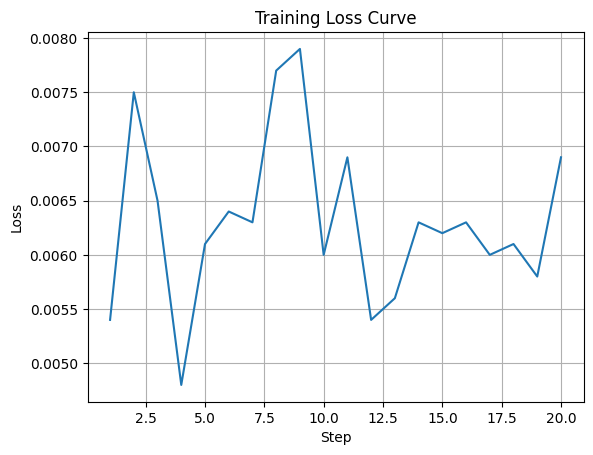

In [11]:
import matplotlib.pyplot as plt

steps = []
losses = []
for record in trainer.state.log_history:
    # 只关心包含 loss 的记录
    if "loss" in record and "step" in record:
        steps.append(record["step"])
        losses.append(record["loss"])

# 绘图
plt.figure()
plt.plot(steps, losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()